In [5]:
import cv2
import os
import numpy as np
from PIL import Image
import os
import json
import matplotlib.pyplot as plt

In [4]:
# Paths
images_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms"
labels_dir = "/Users/finnferchau/dev/EH_Bottle_Dataset/labels"

def center_crop_and_resize(image_path, target_size=(224, 224)):
    """
    Crops the center square of an image and resizes it to the target size.

    Args:
        image_path (str): Path to the input image.
        target_size (tuple): Target size for resizing (width, height).

    Returns:
        PIL.Image.Image: The cropped and resized image.
    """

    image = Image.open(image_path)
    width, height = image.size

    # Calculate the cropping box for a center square
    min_dim = min(width, height)
    left = (width - min_dim) // 2
    top = (height - min_dim) // 2
    right = left + min_dim
    bottom = top + min_dim

    # Crop the center square
    image = image.crop((left, top, right, bottom))

    # Resize to the target size
    image = image.resize(target_size, Image.Resampling.LANCZOS)

    return image

# Load dataset
def load_dataset(images_dir, labels_dir):
    images = []
    labels = []
    for image_file in os.listdir(images_dir):
        if image_file.endswith(".jpg"):
            image_path = os.path.join(images_dir, image_file)
            label_path = os.path.join(labels_dir, image_file.replace(".jpg", ".json"))

            # Load and preprocess image
            image = center_crop_and_resize(image_path, target_size=(224, 224))  # Resize for ResNet50
            images.append(np.array(image) / 255.0)  # Normalize to [0, 1]

            # Load label
            with open(label_path, 'r') as f:
                label = json.load(f)
                labels.append([label["red_count"], label["green_count"], label["blue_count"]])

    return np.array(images), np.array(labels)

images, labels = load_dataset(images_dir, labels_dir)

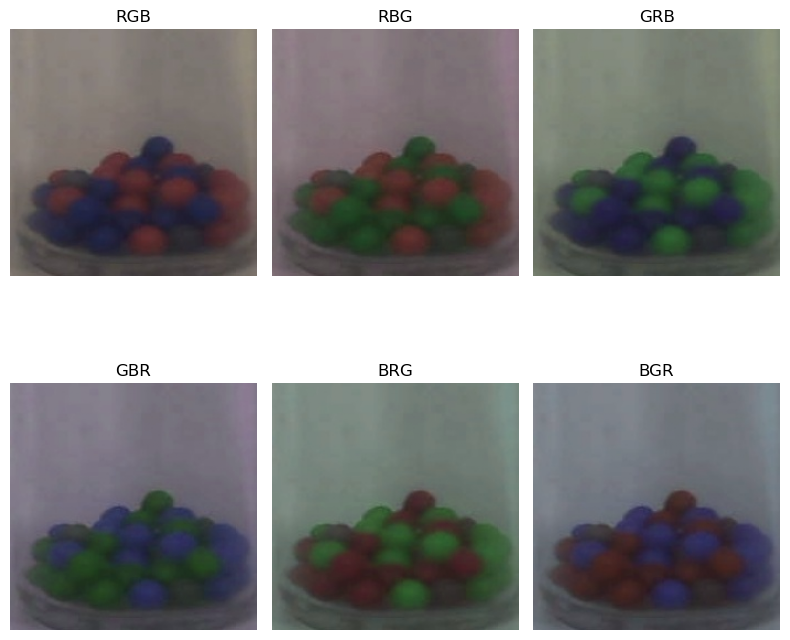

In [7]:


def switch_color_channels(image):
    """
    Generate all permutations of color channels for the given image.
    
    Args:
        image (np.ndarray): The input image in RGB format.
    
    Returns:
        List[np.ndarray]: List of images with swapped color channels.
    """
    # Original channel order (RGB)
    channels = ['RGB', 'RBG', 'GRB', 'GBR', 'BRG', 'BGR']

    # Permutations of the channels
    channel_permutations = [
        (0, 1, 2),  # RGB (original)
        (0, 2, 1),  # RBG
        (1, 0, 2),  # GRB
        (1, 2, 0),  # GBR
        (2, 0, 1),  # BRG
        (2, 1, 0)   # BGR
    ]

    augmented_images = []
    for perm in channel_permutations:
        swapped_image = image[:, :, list(perm)]  # Rearrange the channels
        augmented_images.append(swapped_image)

    return augmented_images, channels

aug_img, channels = switch_color_channels(images[0])
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
axs = axs.flatten()
for idx, (image, channel) in enumerate(zip(aug_img, channels)):
    axs[idx].imshow(image)
    axs[idx].set_title(channel)
    axs[idx].axis("off")
plt.tight_layout()
plt.show()

In [14]:
def augment_images(image_dir_path, labels_dir_path, save_folder):
    """
    Augments images by switching color channels, updates the JSON labels accordingly, and saves the augmented images and labels.

    Args:
        image_dir_path (str): Path to the input images.
        labels_dir_path (str): Path to the corresponding JSON labels.
        save_folder (str): Path to save the augmented images and labels.
        target_size (int): Target size for resizing augmented images (default: 224x224).
    """

    # Ensure the save folder exists
    os.makedirs(save_folder, exist_ok=True)

    image_path_save = os.path.join(save_folder, "images_augmented")
    labels_path_save = os.path.join(save_folder, "labels_augmented")

    # Create directories for augmented data
    os.makedirs(image_path_save, exist_ok=True)
    os.makedirs(labels_path_save, exist_ok=True)

    # Channel permutations and respective labels
    channel_permutations = [
        ('RGB', (0, 1, 2)),  # Original
        ('RBG', (0, 2, 1)),
        ('BRG', (2, 0, 1)),
        ('BGR', (2, 1, 0)),
        ('GRB', (1, 0, 2)),
        ('GBR', (1, 2, 0))
    ]

    # Iterate through all image files
    for file_name in os.listdir(image_dir_path):
        image_path = os.path.join(image_dir_path, file_name)

        if file_name.endswith(".jpg"):
            # Load image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Could not read {image_path}. Skipping.")
                continue

            # Load label
            label_path = os.path.join(labels_dir_path, file_name.replace(".jpg", ".json"))
            if not os.path.exists(label_path):
                print(f"Label file {label_path} not found. Skipping.")
                continue

            with open(label_path, 'r') as f:
                label = json.load(f)

            # Extract the original counts
            red_count = label["red_count"]
            green_count = label["green_count"]
            blue_count = label["blue_count"]

            # Perform augmentation for each channel permutation
            for channel_name, channel_order in channel_permutations[1:]:
                # Rearrange the color channels
                aug_image = image[:, :, list(channel_order)]

                # Update the label
                new_label = label.copy()
                new_label["image_id"] = f"{file_name.split('.')[0]}_{channel_name}.jpg"

                # Swap the pellet counts according to the channel permutation
                counts = [red_count, green_count, blue_count]
                new_label["red_count"], new_label["green_count"], new_label["blue_count"] = [counts[i] for i in channel_order]

                # Save augmented image
                save_path_img = os.path.join(image_path_save, new_label["image_id"])
                cv2.imwrite(save_path_img, aug_image)

                # Save updated label
                save_path_label = os.path.join(labels_path_save, f"{file_name.split('.')[0]}_{channel_name}.json")
                with open(save_path_label, 'w') as label_file:
                    json.dump(new_label, label_file)

                print(f"Processed and saved: {save_path_img} and {save_path_label}")

# Example usage
image_dir_path = "/Users/finnferchau/dev/EH_Bottle_Dataset/cropped_bottoms"  # Path to your images
labels_dir_path = "/Users/finnferchau/dev/EH_Bottle_Dataset/labels"  # Path to your labels
save_folder = "/Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset"  # Folder to save augmented data

# Run the function
augment_images(image_dir_path, labels_dir_path, save_folder)

Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/images_augmented/img_20241125_103815_RBG.jpg and /Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/labels_augmented/img_20241125_103815_RBG.json
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/images_augmented/img_20241125_103815_BRG.jpg and /Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/labels_augmented/img_20241125_103815_BRG.json
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/images_augmented/img_20241125_103815_BGR.jpg and /Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/labels_augmented/img_20241125_103815_BGR.json
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/images_augmented/img_20241125_103815_GRB.jpg and /Users/finnferchau/dev/EH_Bottle_Dataset/augmented_dataset/labels_augmented/img_20241125_103815_GRB.json
Processed and saved: /Users/finnferchau/dev/EH_Bottle_Dataset/au

In [11]:
label_path = "/Users/finnferchau/dev/EH_Bottle_Dataset/labels/img_20241125_082521.json"
with open(label_path, 'r') as f:
    label = json.load(f)
label["image_id"]

'img_20241125_082521.jpg'